# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

In [2]:
import cv2

We set the random seed so that the results don't vary drastically.

In [3]:
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(30)
rn.seed(30)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(30)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
train_batch_size = 16
valid_batch_size = 16

In [6]:
# specify image size and channels
img_channels = 3
img_rows = 80
img_cols = 80
img_frms = 15

# number of classes
nb_classes = 5

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def load_batch_data(source_path, folder_list, batch_size, t, batch):
    img_idx = [x for x in range(0,30) if x%2 ==1]#create a list of image numbers you want to use for a particular video
    batch_data = np.zeros((batch_size,len(img_idx),img_rows,img_cols,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape[0] != image.shape[1]:
                image = image[0:120,20:140]
            image = cv2.resize(image,(img_rows,img_cols))

            batch_data[folder,idx,:,:,0] = image[:,:,0]/image[:,:,0].max()#normalise and feed in the image
            batch_data[folder,idx,:,:,1] = image[:,:,0]/image[:,:,1].max()#normalise and feed in the image
            batch_data[folder,idx,:,:,2] = image[:,:,0]/image[:,:,2].max()#normalise and feed in the image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
    

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield load_batch_data(source_path, folder_list, batch_size, t, batch) #you yield the batch_data and the batch_labels, remember what does yield do

        
        # code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_data(source_path, folder_list, batch_size, t, batch)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import cv2


input_shape=(img_frms,img_rows,img_cols,img_channels)

#Define model
model = Sequential()


model.add(Conv3D(16, kernel_size=(3, 3,3),padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv3D(16, kernel_size=(3, 3, 3),padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Conv3D(32, kernel_size=(3, 3, 3),padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(32, kernel_size=(3, 3, 3),padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))


model.add(Conv3D(64, kernel_size=(2, 3, 3),padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(64, kernel_size=(2, 3, 3),padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))


          
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu')) # fully connected
#model.add(Dropout(0.50))

model.add(Dense(128, activation='relu')) # fully connected
#model.add(Dropout(0.50))

# softmax layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
activation_29 (Activation)   (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 15, 80, 80, 16)    6928      
_________________________________________________________________
batch_normalization_21 (Batc (None, 15, 80, 80, 16)    64        
_________________________________________________________________
activation_30 (Activation)   (None, 15, 80, 80, 16)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 40, 40, 16)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 40, 40, 16)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, train_batch_size)
val_generator = generator(val_path, val_doc, valid_batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:

if (num_train_sequences%train_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/train_batch_size)
else:
    steps_per_epoch = (num_train_sequences//train_batch_size) + 1

if (num_val_sequences%valid_batch_size) == 0:
    validation_steps = int(num_val_sequences/valid_batch_size)
else:
    validation_steps = (num_val_sequences//valid_batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
hist = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16
42/42 [==============================] - 70s 2s/step - loss: 9.8725 - categorical_accuracy: 0.3078 - val_loss: 10.6613 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-09-2010_21_14.764750/model-00001-9.88126-0.30618-10.66126-0.26000.h5
Epoch 2/50
42/42 [==============================] - 27s 647ms/step - loss: 10.3597 - categorical_accuracy: 0.3231 - val_loss: 10.9541 - val_categorical_accuracy: 0.3214

Epoch 00002: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-09-2010_21_14.764750/model-00002-10.35967-0.32313-10.95411-0.32143.h5
Epoch 3/50
42/42 [==============================] - 29s 692ms/step - loss: 3.1779 - categorical_accuracy: 0.2721 - val_loss: 2.0098 - val_categorical_accuracy: 0

<b>We Selected the model at Epoch 47, which gave training accuracy of 96.83% and validation accuracy of 92.86% </b>

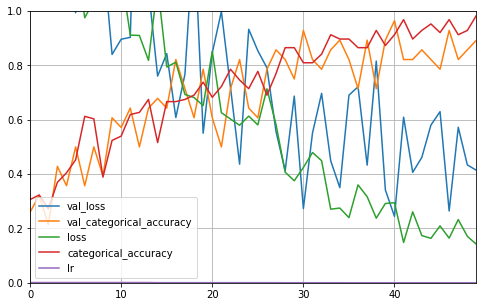

In [20]:
import pandas as pd
pd.DataFrame(hist.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()